# REINFORCE (a.k.a (Vanila) Policy Gradient)

tasks adapted from https://github.com/yandexdataschool/Practical_RL/ week6 



## Install dependencies

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# CartPole

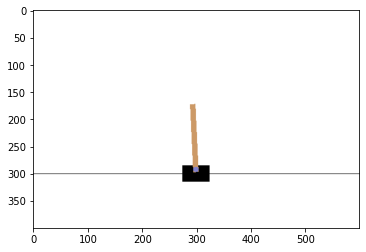

In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")


if hasattr(env, 'env'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


In [5]:
agent = nn.Sequential(
    nn.Linear(state_dim[0], 100),
    nn.ReLU(),
    nn.Linear(100, 200),
    nn.ReLU(),
    nn.Linear(200, n_actions)
)

print(agent)

Sequential(
  (0): Linear(in_features=4, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=2, bias=True)
)


In [6]:
def predict_proba(states):
    
    states = torch.tensor(states, dtype=torch.float) 
    logits = agent(states)
    probs = F.softmax(logits, dim=-1)
    probs = probs.detach().numpy()
    return probs
    

In [7]:
s = env.reset()
predict_proba(s)

array([0.4838057 , 0.51619434], dtype=float32)

In [8]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
assert isinstance(
    test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (
    test_states.shape[0], n_actions), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1),
                   1), "probabilities do not sum to 1"

# Play the game

In [9]:
def generate_session(t_max=1000):
    

    
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        
        action_probas = predict_proba(np.array([s]))[0]

       
        a = np.random.choice(n_actions,1,p=action_probas)[0]
        
        new_s, r, done, info = env.step(a)

       
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [10]:
states, actions, rewards = generate_session()

# Computing cumulative rewards

In [11]:

def get_cumulative_rewards(rewards,  
                           gamma=0.99):
    
    
    cum_rewards = np.zeros_like(rewards, dtype=np.float64)
    gamma_reward = 0
    for num_rew, curr_rew in zip(range(len(rewards) - 1, -1, -1), reversed(rewards)):
        cum_rewards[num_rew] = rewards[num_rew] + gamma * gamma_reward
        gamma_reward = cum_rewards[num_rew]

    return cum_rewards
    
    

In [12]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#Loss function and updates
We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$
Following the REINFORCE algorithm, we can define our objective as follows:

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$
When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient

In [13]:

def to_one_hot(y_tensor, n_dims=None):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(
        y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [14]:
optimizer = torch.optim.Adam(agent.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    logits = agent(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    J_hat = torch.mean(log_probs_for_actions * cumulative_returns)
    entropy = - (probs * log_probs).sum(dim=-1).mean()
    loss = - J_hat - entropy_coef * entropy

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return np.sum(rewards)

# Playing the game



In [15]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        action_probas = predict_proba(np.array([s]))[0] 
        
        
        a = np.random.choice(n_actions,1,p=action_probas)[0]
        
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    return states, actions, rewards

In [16]:
states, actions, rewards = generate_session()

# Train

In [17]:
for i in range(100):
    
    rewards = [train_on_session(*generate_session()) for _ in range(100)] 
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 500:
        print ("You Win!") 
        break
        


mean reward:45.770
mean reward:107.650
mean reward:110.400
mean reward:193.380
mean reward:49.340
mean reward:97.750
mean reward:232.240
mean reward:94.090
mean reward:443.510
mean reward:383.860
mean reward:260.540
mean reward:233.920
mean reward:99.210
mean reward:122.420
mean reward:224.870
mean reward:415.070
mean reward:363.070
mean reward:130.610
mean reward:121.100
mean reward:129.430
mean reward:55.330
mean reward:89.510
mean reward:48.400
mean reward:78.590
mean reward:61.160
mean reward:37.790
mean reward:84.180
mean reward:112.580
mean reward:598.870
You Win!


# Make video of agent's play

In [18]:
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="./videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [19]:
import glob
mp4list = glob.glob('videos/*.mp4')
mp4list

['videos/openaigym.video.0.123.video000008.mp4',
 'videos/openaigym.video.0.123.video000064.mp4',
 'videos/openaigym.video.0.123.video000001.mp4',
 'videos/openaigym.video.0.123.video000027.mp4',
 'videos/openaigym.video.0.123.video000000.mp4']

In [20]:
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML

def show_video(name):  
  if len(mp4list) > 0:
    mp4 = name
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [21]:
show_video(mp4list[3])